<a href="https://colab.research.google.com/github/cdiegor/Metaheuristicas/blob/main/PRV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema de Roteamento de Veículos

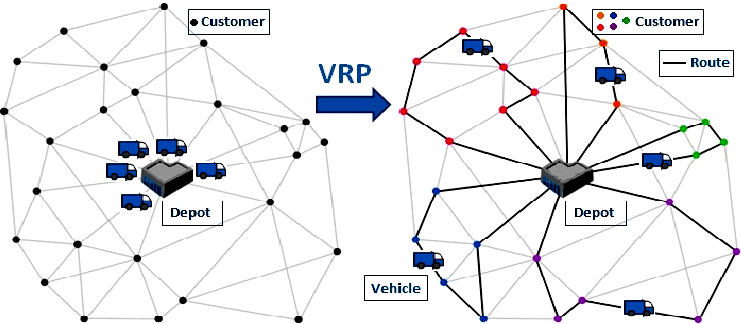

## Introdução

O problema de roteamento de veículos (PRV) é um problema de otimização combinatória e programação inteira que pergunta "Qual é o conjunto ideal de rotas para uma frota de veículos percorrer a fim de entregar a um determinado conjunto de clientes?" Generaliza o problema do caixeiro viajante (PCV). Apareceu pela primeira vez em um artigo de George Dantzig e John Ramser em 1959 [1], no qual a primeira abordagem algorítmica foi escrita e aplicada a entregas de gasolina. Frequentemente, o contexto é o da entrega de mercadorias localizadas em um depósito central para clientes que fizeram pedidos dessas mercadorias. O objetivo do PRV é minimizar o custo total da rota. Em 1964, Clarke e Wright aprimoraram a abordagem de Dantzig e Ramser usando um algoritmo guloso eficaz chamado algoritmo de economia.

Determinar a solução ótima para VRP é NP-difícil[2], então o tamanho dos problemas que podem ser resolvidos de forma ótima usando programação matemática ou otimização combinatória pode ser limitado. Portanto, os solucionadores comerciais tendem a usar heurísticas devido ao tamanho e à frequência dos PRVs do mundo real que precisam resolver.

O PRV tem muitas aplicações diretas na indústria. Os fornecedores de ferramentas de roteamento PRV geralmente afirmam que podem oferecer economia de custos de 5% a 30%.

Fonte: Wikipedia. *Vehicle routing problem*. Acessível em: https://en.wikipedia.org/wiki/Vehicle_routing_problem


[1] Dantzig, George Bernard; Ramser, John Hubert (October 1959). "The Truck Dispatching Problem" (PDF). Management Science. 6 (1): 80–91. doi:10.1287/mnsc.6.1.80.

[2]  Toth, P.; Vigo, D., eds. (2002). The Vehicle Routing Problem. Monographs on Discrete Mathematics and Applications. Vol. 9. Philadelphia: Society for Industrial and Applied Mathematics. ISBN 0-89871-579-2.

In [1]:
import matplotlib.pyplot as plt
import math
import random
import time
import itertools
import urllib
import csv

### Variantes

Existem diversas variações e especializações do problema de roteamento de veículos:

*    Problema de Roteamento de Veículos com Lucros (PRVL): Um problema de maximização onde não é obrigatório visitar todos os clientes. O objetivo é visitar uma vez os clientes maximizando a soma dos lucros arrecadados respeitando o limite de tempo de um veículo. Os veículos são obrigados a começar e terminar no depósito.

*    Problema de roteamento de veículos com coleta e entrega (PRVCE): Várias mercadorias precisam ser movidas de determinados locais de coleta para outros locais de entrega. O objetivo é encontrar rotas ideais para uma frota de veículos visitar os locais de embarque e desembarque.

*    Problema de roteamento de veículos com pilha: Semelhante ao PRVCE, exceto que uma restrição adicional é colocada no carregamento dos veículos: em qualquer local de entrega, o item a ser entregue deve ser o item retirado mais recentemente. Esse esquema reduz os tempos de carga e descarga nos locais de entrega, pois não há necessidade de descarregar temporariamente outros itens além daqueles que devem ser deixados.

*    Problema de roteamento de Veículos com Janelas de Tempo (PRVJT): Os locais de entrega possuem janelas de tempo dentro das quais as entregas (ou visitas) devem ser feitas.

*    Problema de Roteamento de Veículo Capacitado: PRVC ou PRVCJT. Os veículos têm uma capacidade limitada de carga das mercadorias que devem ser entregues.

*    Problema de Roteamento de Veículos com Múltiplas Viagens (PRVMV): Os veículos podem fazer mais de uma rota.

*    Problema de Roteamento de Veículo Aberto (PRVA): Os veículos não são obrigados a retornar ao depósito.

*    Problema de Roteamento de Inventário (PRI): Os veículos são responsáveis por atender as demandas em cada ponto de entrega.

*    Problema de roteamento de veículos com vários depósitos (PRVMD): Existem vários depósitos a partir dos quais os veículos podem começar e terminar.

*    Problema de roteamento de veículos com transferências (PRVT): As mercadorias podem ser transferidas entre veículos em centros de transferência especialmente designados.

Vários fornecedores de software criaram produtos de software para resolver vários problemas de PRV. Numerosos artigos estão disponíveis para mais detalhes sobre suas pesquisas e resultados.


Fonte: Wikipedia. *Vehicle routing problem*. Acessível em: https://en.wikipedia.org/wiki/Vehicle_routing_problem

### Definição do nosso problema

Dado este vasto universo acerca do problema de roteamento de veículos precisamos situar nosso estudo em um problema específico e fazer considerações mais precisas sobre o que queremos resolver.

Vamos considerar que temos como entrada um grafo $G = (V, A)$ completo no qual um nó específico é chamado de depósito. Os demais nós do grafo são os clientes. Para qualquer arco $(u,v) \in A$, vamos considerar conhecida uma métrica $c(u,v)$ o custo de transporte entre os nós $u$ e $v$. Com uma frota limitada em $R$ veículos, queremos determinar qual é o conjunto de rotas a serem repartidas entre eles de forma a atender todos os clientes com um custo total de transporte mínimo.

Por simplicidade, vamos reproduzir o que foi realizado no problema do caixeiro viajante e considerar que cada vértice do grafo é um ponto num espaço euclidiano $\mathbb{R}^2$ e que a métrica de distância é a própria distância euclidiana.

In [2]:
distancia = math.dist

In [3]:
def tamanho_rota(rota):
  "A distância total percorrida entre dois pares consecutivos em uma rota"
  return sum(distancia(rota[i-1], rota[i]) for i in range(len(rota)))

In [4]:
  class PRV:
    def __init__(self):
      self.clientes = []
      self.R = 0
      self.rotas = []

    def custo(self):
      return sum(tamanho_rota(x) for x in self.rotas)

    def __repr__(self):
      return f"Clientes = {len(self.clientes)-1}\tVeiculos = {self.R}\tCusto = {self.custo()}"
    def __str__(self):
      return f"Clientes = {len(self.clientes)-1}\tVeiculos = {self.R}\tCusto = {self.custo()}"

### Construindo instâncias fictícias

A seguinte funçao ```gerar_prv``` recebe como parâmetros o número de clientes, uma quantidade de veículos e gera uma instância do PRV com estas características. Para um melhor efeito visual vamos situar o depósito inicial no centro do mapa.

In [5]:
def gerar_prv (n, r, largura=900, altura=900, rseed=233):
  "Faz um conjunto com n clientes, com coordenadas aleatórias no máximo (largura x alutura)"
  prv = PRV()
  random.seed(rseed)
  prv.R = r
  prv.clientes = [ [random.randrange(largura), random.randrange(altura)] for c in range(n+1) ]
  prv.clientes[0] = [largura//2, altura//2]
  return prv

#TO DO: gerar clientes segundo uma gaussiana 2d

### Desenhando a solução

In [6]:
def plot_rota(rota, cor):
  x = []
  y = []
  for i in range(len(rota)):
    x.append(rota[i][0])
    y.append(rota[i][1])

  for i in range(len(rota)):
    plt.plot([x[i], x[i-1]], [y[i], y[i-1]], color=cor, linewidth=2)

  plt.scatter(x, y, color=cor, linewidth=3)

#TO DO: simplificar essa função sem x e y

In [7]:
import seaborn as sns;
def plot_prv(prv):

  print(prv)

  palette = itertools.cycle(sns.color_palette("colorblind", prv.R))
  for rota in prv.rotas:
    plot_rota(rota, next(palette))

  plt.plot(prv.clientes[0][0], prv.clientes[0][1],
           marker="D", markersize=10, markeredgecolor="black", markerfacecolor="grey")
  plt.axis("scaled")

  plt.show()


[[450, 450], [643, 178], [537, 236], [819, 870], [495, 564], [209, 85], [853, 104], [275, 239], [710, 733], [14, 78], [692, 243]]
Clientes = 10	Veiculos = 3	Custo = 6256.003330634088


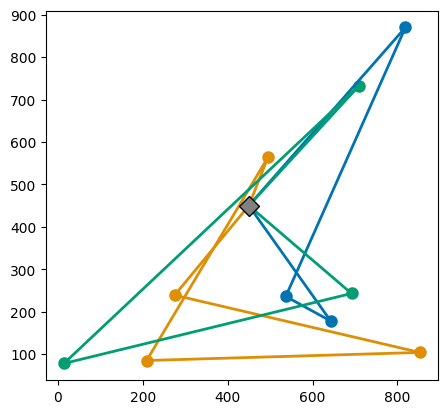

In [8]:
prv = gerar_prv(10, 3)
print(prv.clientes)
prv.rotas.append([prv.clientes[0], prv.clientes[1], prv.clientes[2], prv.clientes[3]])
prv.rotas.append([prv.clientes[0], prv.clientes[4], prv.clientes[5], prv.clientes[6], prv.clientes[7]])
prv.rotas.append([prv.clientes[0], prv.clientes[8], prv.clientes[9], prv.clientes[10]])
plot_prv(prv)

## Metaheurísticas para o PRV

### Solução inicial

Antes de fazermos uma metaheurística para o PRV, é preciso pensar em uma solução inicial construtiva. Podemos então pensar que a solução deste problema pode ser dividida em duas etapas:

1.   Dividir os clientes entre os veículos (agrupar).
2.   Resolver um Problema do Caixeiro Viajante para cada veículo.

Vamos então elaborar uma heurística construtiva que inicialmente agrupa os clientes e em seguida podemos utilizar uma heurística construtiva para o PCV para a segunda parte.

#### Algoritmo de agrupamento: K-Means

In [9]:
import numpy as np
def kmeans(prv):
  max_iter = 100

  clientes = prv.clientes[1:len(prv.clientes)]

  # Inicializar os centroides aleatoriamente
  centroides = random.sample(clientes, prv.R)

  for i in range(max_iter):
    # Designar cada cliente para um veiculo
    prv.rotas = [[] for _ in range(prv.R)]
    for x in clientes:
        distances = [distancia(x,c) for c in centroides]
        centroide_mais_proximo = np.argmin(distances)
        prv.rotas[centroide_mais_proximo].append(x)

    # Atualizar centroides
    prox_centroides = []
    for c in prv.rotas:
        if len(c) > 0:
            novo_centro = np.mean(c, axis=0)
            prox_centroides.append(novo_centro)
        else:
            prox_centroides.append(centroides[np.random.choice(prv.R)])

    # Verificar convergência
    if np.allclose(centroides, prox_centroides): break
    centroides = prox_centroides
  return prv

#### Algoritmo construtivo para o PCV


In [10]:
def vizinho_mais_proximo(cidades):
    """Comece a rota na primeira cidade; a cada passo estenda a rota
    movendo-se da cidade anterior para a vizinha mais próxima
    que ainda não foi visitada."""
    primeira = cidades[0]
    rota = [primeira]
    inexploradas = cidades.copy()
    inexploradas.remove(primeira)
    while inexploradas:
        C = mais_proxima(rota[-1], inexploradas)
        rota.append(C)
        inexploradas.remove(C)
    return rota

def mais_proxima(c, cidades):
    "Encontre a cidade mais próxima da cidade c."
    return min(cidades, key=lambda x: distancia(c, x))

#### Unindo as partes: um algoritmo construtivo para o PRV

In [11]:
def solucao_inicial(prv):
  prv = kmeans(prv)
  for i in range(len(prv.rotas)):
    prv.rotas[i].insert(0, prv.clientes[0])
    prv.rotas[i] = vizinho_mais_proximo(prv.rotas[i])
  return prv

Clientes = 100	Veiculos = 3	Custo = 9902.644901416139


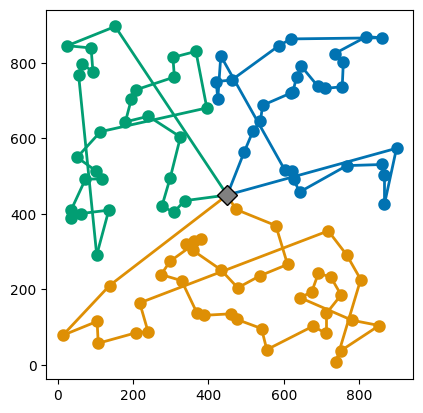

In [12]:
plot_prv(solucao_inicial(gerar_prv(100, 3)))

### Um operador de modificação

Para fazermos uso de nossas soluções metaheurísticas é preciso definir um operador de modificação estocástico que posteriormente pode ser utilizado para definirmos os conjuntos de vizinhança.

Vamos utilizar um operador chamado ```ciclar``` que encontra um cliente no roteamento e troca a posição dele com o seu sucessor. Caso ele seja o último daquela rota (e portanto seu sucessor é o próprio depósito), então este cliente passa a ser atendido pelo próximo veículo (em uma lista cíclica).

In [13]:
def ciclar(prv, j):
  for i in range(len(prv.rotas)):
    try:
      index = prv.rotas[i].index(prv.clientes[j])
      if index == 1:
        prv.rotas[i-1].append(prv.clientes[j])
        del prv.rotas[i][index]
      else:
        prv.rotas[i][index], prv.rotas[i][index-1] = prv.rotas[i][index-1], prv.rotas[i][index]
    except ValueError:
      pass

In [14]:
import copy

def modificar(S):
  j = random.randrange(1, len(S.clientes))
  R = copy.deepcopy(S)
  ciclar(R, j)
  return R


### Uma metaheurística utilizando este operador

In [15]:
import copy
import time

def recozimento_simulado_ciclar(prv):

  start = time.time()
  iteracao = 1
  temperatura = resfriamento(prv, iteracao)
  historico = []
  S = solucao_inicial(prv)
  while temperatura > 1/(prv.R*len(prv.clientes)) and time.time()-start < len(prv.clientes)/5:
    R = modificar(S)
    delta = R.custo() - S.custo()
    if delta < 0:
      S = copy.deepcopy(R)
      historico.append([iteracao, S.custo(), temperatura])
      if S.custo() < prv.custo():
          prv = copy.deepcopy(S)
    else:
      probabilidade = np.exp(-delta / temperatura)
      if np.random.uniform() < probabilidade:
          S = copy.deepcopy(R)
          historico.append([iteracao, S.custo(), temperatura])
    iteracao += 1
    temperatura = resfriamento(prv, iteracao)
  return prv, historico

In [16]:
def resfriamento(prv, iteracao):
  return (len(prv.clientes)**2)*(0.999)**iteracao


Custo inicial =  7066.908079855173
Clientes = 50	Veiculos = 3	Custo = 7059.168959189166


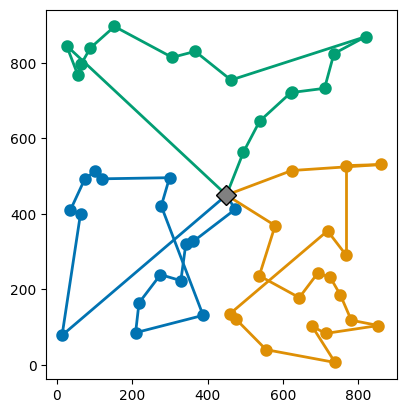

[[450, 450], [473, 412], [362, 327], [342, 319], [329, 223], [275, 239], [218, 164], [209, 85], [388, 131], [277, 421], [299, 496], [119, 493], [102, 514], [74, 492], [36, 410], [63, 401], [14, 78]]
[[450, 450], [579, 369], [537, 236], [643, 178], [692, 243], [725, 232], [752, 185], [781, 118], [853, 104], [713, 83], [677, 102], [738, 6], [555, 40], [476, 120], [459, 135], [718, 355], [767, 291], [767, 528], [861, 531], [623, 515]]
[[450, 450], [495, 564], [538, 646], [620, 721], [624, 722], [710, 733], [735, 825], [819, 870], [462, 755], [367, 831], [306, 815], [153, 897], [89, 840], [65, 798], [56, 768], [26, 846]]


In [17]:
prv, hist = recozimento_simulado_ciclar(gerar_prv(50, 3))
print('Custo inicial = ', hist[0][1])
plot_prv(prv)
for rota in prv.rotas: print(rota)


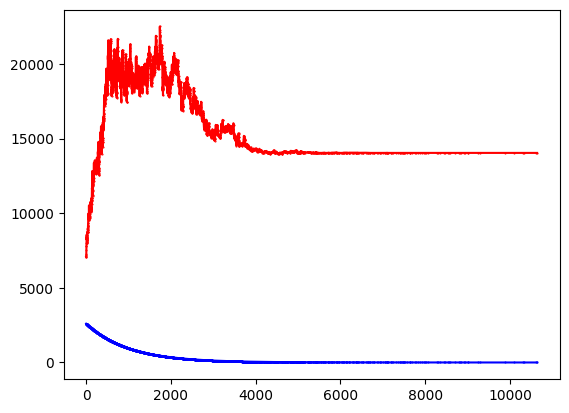

In [18]:
x = []
y = []
z = []
for h in hist:
  x.append(h[0])
  y.append(h[1])
  z.append(h[2])

plt.plot(x,y,  'r.-', markersize=1)
plt.plot(x,z,  'b.-', markersize=1)

### Melhorando o operador

In [19]:
import copy

def encontrar(S, j):
  index = -1
  for i in range(S.R):
    try:
      index = S.rotas[i].index(S.clientes[j])
    except ValueError:
      pass
    if index >= 0: break
  return i, index

def trocar(S, i, j):
  ri, li = encontrar(S, i)
  rj, lj = encontrar(S, j)
  del S.rotas[ri][li]
  prv.rotas[ri].insert(li, S.clientes[j])
  del S.rotas[rj][lj]
  prv.rotas[rj].insert(lj, S.clientes[i])

def inverter(S, i, j):
  ri, li = encontrar(S, i)
  rj, lj = encontrar(S, j)
  if ri == rj:
    if li < lj:
       S.rotas[ri][li:lj+1] = reversed(S.rotas[ri][li:lj+1])
    else:
       S.rotas[rj][lj:li+1] = reversed(S.rotas[rj][lj:li+1])


def puxar(S, i, j):
  rj, lj = encontrar(S, j)
  del S.rotas[rj][lj]
  ri, li = encontrar(S, i)
  S.rotas[ri].insert(li, S.clientes[j])


def modificar_3ops(S):
  i = random.randrange(len(S.clientes)-1) + 1
  j = random.randrange(len(S.clientes)-1) + 1
  R = copy.deepcopy(S)
  if (i == j):
    ciclar(R, j)
  else:
    ri, li = encontrar(S, i)
    rj, lj = encontrar(S, j)
    if (ri == rj): inverter(R, i, j)
    else: puxar(S, i, j)
  return R


In [20]:
import copy
import time

def recozimento_simulado_3ops(prv):

  start = time.time()
  iteracao = 1
  temperatura = resfriamento(prv, iteracao)
  historico = []
  S = solucao_inicial(prv)
  while temperatura > 1/(prv.R*len(prv.clientes)) and time.time()-start < len(prv.clientes)/2:
    R = modificar_3ops(S)
    delta = R.custo() - S.custo()
    if delta < 0:
      S = copy.deepcopy(R)
      historico.append([iteracao, S.custo(), temperatura])
      if S.custo() < prv.custo():
          prv = copy.deepcopy(S)
    else:
      probabilidade = np.exp(-delta / temperatura)
      if np.random.uniform() < probabilidade:
          S = copy.deepcopy(R)
          historico.append([iteracao, S.custo(), temperatura])
    iteracao += 1
    temperatura = resfriamento(prv, iteracao)
  return prv, historico

Custo inicial =  7059.168959189166
Clientes = 50	Veiculos = 3	Custo = 6425.540724851192


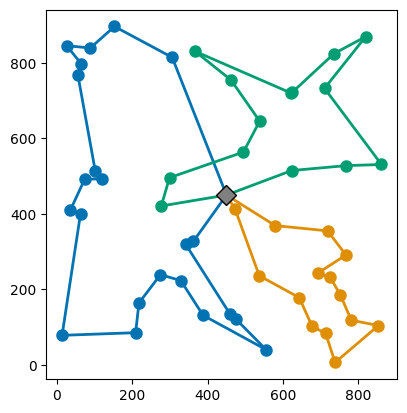

[[450, 450], [306, 815], [153, 897], [89, 840], [26, 846], [65, 798], [56, 768], [102, 514], [119, 493], [74, 492], [36, 410], [63, 401], [14, 78], [209, 85], [218, 164], [275, 239], [329, 223], [388, 131], [555, 40], [476, 120], [459, 135], [342, 319], [362, 327]]
[[450, 450], [579, 369], [718, 355], [767, 291], [692, 243], [725, 232], [752, 185], [781, 118], [853, 104], [738, 6], [713, 83], [677, 102], [643, 178], [537, 236], [473, 412]]
[[450, 450], [623, 515], [767, 528], [861, 531], [710, 733], [819, 870], [735, 825], [624, 722], [620, 721], [367, 831], [462, 755], [538, 646], [495, 564], [299, 496], [277, 421]]


In [21]:
prv , hist = recozimento_simulado_3ops(gerar_prv(50, 3))
print('Custo inicial = ', hist[0][1])
plot_prv(prv)
for rota in prv.rotas: print(rota)

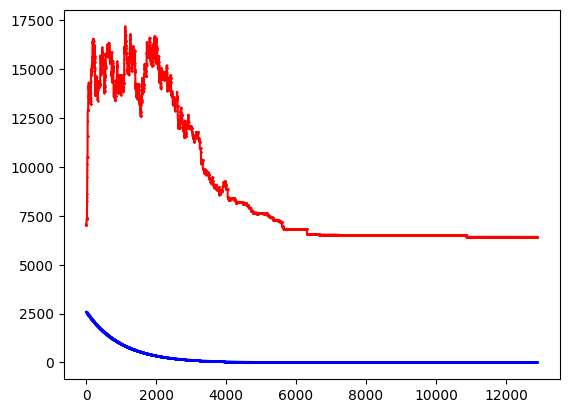

In [22]:
x = []
y = []
z = []
for h in hist:
  x.append(h[0])
  y.append(h[1])
  z.append(h[2])

plt.plot(x,y,  'r.-', markersize=1)
plt.plot(x,z,  'b.-', markersize=1)

### Definindo uma vizinhança e uma busca tabu

Observe que para qualquer par de valores $(i, j)$ no conjunto de clientes temos uma modificação válida para dar seguimento ao recozimento simulado. Vamos definir portanto uma vizinhança $N(S)$ de uma solução $S$ como o conjunto de pares soluções que podem ser obtidas aplicando-se uma modificação sobre $S$ para qualquer par $(i, j)$ de clientes.

In [23]:
def modifix(S, i, j):
  R = copy.deepcopy(S)
  if (i == j):
    ciclar(R, j)
  else:
    ri, li = encontrar(R, i)
    rj, lj = encontrar(R, j)
    if (ri == rj):
      inverter(R, i, j)
    else:
      puxar(R, i, j)
  return R

def vizinhanca(S):
  return [ modifix(S, i, j) for i in range(1, len(S.clientes)) for j in range(1, len(S.clientes)) ]

Para uma busca tabu nosso interesse é filtrar aquelas soluções que não correspondem ao critério tabu. Dessa forma vamos definir uma função ```vizinhanca_tabu``` que também recebe uma lista tabu de pares $(i, j)$ proibidos e gera uma lista de vizinhos apenas se não estiverem presentes na lista tabu.

In [24]:
def vizinhanca_tabu(S, tabu):
  return  [ [modifix(S, i, j), (i, j)] for i in range(1, len(S.clientes)) for j in range(1, len(S.clientes)) if (i,j) not in tabu and (j,i) not in tabu]

In [25]:
def melhor_vizinho(vizinhanca):
  return min(vizinhanca, key = lambda S : S[0].custo())

In [26]:
import copy
import time
import collections

def busca_tabu_3ops(prv):
  tabu = collections.deque(maxlen=1+len(prv.clientes)//3)
  start = time.time()
  historico = []
  S = solucao_inicial(prv)
  prv = copy.deepcopy(S)
  iteracao = 1
  while time.time()-start < len(prv.clientes)/2:
    [R, tupla] = melhor_vizinho(vizinhanca_tabu(S, tabu))
    S = copy.deepcopy(R)
    if S.custo() < prv.custo():
      prv = copy.deepcopy(S)
    tabu.append(tupla)
    historico.append([iteracao, S.custo(), tupla])
    iteracao += 1
  return prv, historico

Custo inicial =  6728.670378639907
Clientes = 50	Veiculos = 3	Custo = 5915.761352972158


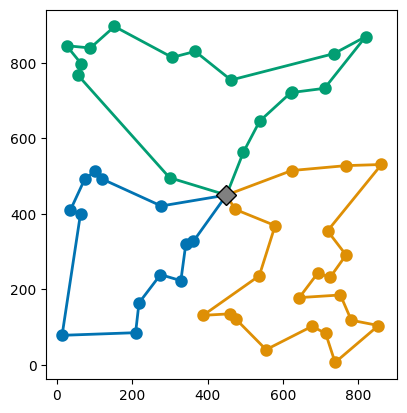

[[450, 450], [277, 421], [119, 493], [102, 514], [74, 492], [36, 410], [63, 401], [14, 78], [209, 85], [218, 164], [275, 239], [329, 223], [342, 319], [362, 327]]
[[450, 450], [473, 412], [579, 369], [537, 236], [388, 131], [459, 135], [476, 120], [555, 40], [677, 102], [713, 83], [738, 6], [853, 104], [781, 118], [752, 185], [643, 178], [692, 243], [725, 232], [767, 291], [718, 355], [861, 531], [767, 528], [623, 515]]
[[450, 450], [495, 564], [538, 646], [620, 721], [624, 722], [710, 733], [819, 870], [735, 825], [462, 755], [367, 831], [306, 815], [153, 897], [89, 840], [26, 846], [65, 798], [56, 768], [299, 496]]


In [27]:
prv, hist = busca_tabu_3ops(gerar_prv(50, 3))
print('Custo inicial = ', hist[0][1])
plot_prv(prv)
for rota in prv.rotas: print(rota)

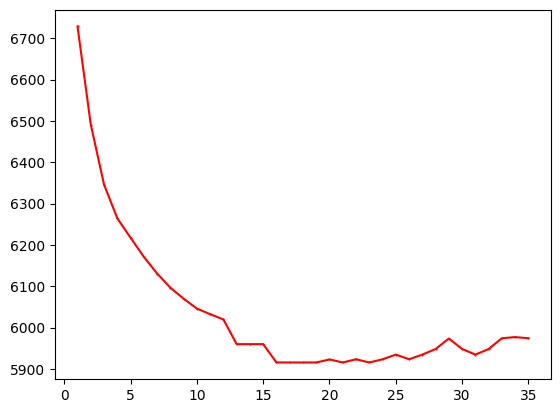

In [28]:
x = []
y = []
for h in hist:
  x.append(h[0])
  y.append(h[1])

plt.plot(x,y,  'r.-', markersize=1)

# Avaliando Metaheurísticas

Um momento importante na tomada de decisão com metaheurísticas é caracterizar qual a melhor metaheurística que podemos fazer. Isto envolve não apenas a definição da metodologia, algoritmos e operadores, mas também uma parametrização eficiente.

Não há, contudo, uma forma teórica de reconhecer bons parâmetros (embora a teoria forneça limites inferiores e superiores). Na prática precisamos realizar testes, simulações com diversos valores na busca da melhor versão.

Para isto vamos definir as seguintes funções de medição de tempo e qualidade da solução. Primeiramente uma função que recebe como entrada uma outra função e um conjunto de dados a ser passado para esta função e marca o tempo de execução.

In [ ]:

def benchmark(funcao, entrada):
    "Roda uma uma função e retorna um par (tempo, resultados)."
    t0           = time.process_time()
    resultados = [funcao(x) for x in entrada]
    t1           = time.process_time()
    tempo_medio  = (t1 - t0) / len(entrada)
    return (tempo_medio, resultados)

In [ ]:
benchmark(abs, range(-10,10))

(4.969500000839843e-07,
 [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Como temos interesse em executar diversas parametrizações do algoritmo, vamos definir uma função que recebe diversos algoritmos e imprime as devidas métricas.

In [ ]:
import statistics
def benchmarks(algoritmos, entradas):
    "Gera uma tabela com os resultados dos algoritmos passados como entrada."
    for algo in algoritmos:
        tempo, res = benchmark(algo, entradas)
        custos = [ x.custo() for x in res ]
        # Exatrair métricas e gerar tabela
        print("{:>25} |{:7.1f} ±{:4.0f} ({:5.0f} a {:5.0f}) |{:7.3f} segs/instancia | {} ⨉ clientes={}/veiculos={}"
              .format(algo.__name__, statistics.mean(custos), statistics.stdev(custos), min(custos), max(custos),
                      tempo, len(entradas), len(entradas[0].clientes)-1, entradas[0].R))

Definidas estas funções precisamos agora de uma função que gera um conjunto de entradas para os possíveis testes.

In [ ]:
def gera_instancias(num_instancias=10, num_clientes=30, num_veiculos=3):
  return tuple(gerar_prv(num_clientes, num_veiculos, rseed=r) for r in range(num_instancias))

Podemos agora definir versões dos algoritmos para testar que recebam também os parâmetros do algoritmo como entrada. Vamos começar com o recozimento simulado. Vamos definir três parâmetros: uma função de resfriamento, um tempo máximo de execução e um número máximo de iterações.

In [ ]:
import copy
import time

def recozimento_simulado( prv,
                          presfriamento = resfriamento,
                          tempo_max = 2,
                          iter_max = 100000 ):

  start = time.time()
  iteracao = 1
  temperatura = presfriamento(prv, iteracao)
  S = solucao_inicial(prv)
  condicao = temperatura > 1/(prv.R*len(prv.clientes)) and time.time()-start < tempo_max and iteracao <= iter_max
  while condicao :
    R = modificar_3ops(S)
    delta = R.custo() - S.custo()
    if delta < 0:
      S = copy.deepcopy(R)
      if S.custo() < prv.custo():
          prv = copy.deepcopy(S)
    else:
      probabilidade = np.exp(-delta / temperatura)
      if np.random.uniform() < probabilidade:
          S = copy.deepcopy(R)
    iteracao += 1
    temperatura = resfriamento(prv, iteracao)
    condicao = temperatura > 1/(prv.R*len(prv.clientes)) and time.time()-start < tempo_max and iteracao < iter_max
  return prv

Para a busca tabu vamos definir o tamanho da lista tabu, o tempo máximo de execução do algoritmo e um limite para o número de soluções avaliadas, o que teria uma equivalência com o número e iterações do recozimento simulado para efeitos de comparação.

In [ ]:
import copy
import time
import collections

def busca_tabu(prv,
               tam_tabu = 5,
               tempo_max = 2,
               aval_max = 100000):
  tabu = collections.deque(maxlen=tam_tabu)
  start = time.time()
  S = solucao_inicial(prv)
  prv = copy.deepcopy(S)
  iteracao = 1
  naval = 1
  condicao = (time.time()-start < tempo_max) and (naval <= aval_max)
  while condicao:
    NS = vizinhanca_tabu(S, tabu)
    [S, tupla] = melhor_vizinho(NS)
    naval += len(NS)
    if S.custo() < prv.custo():
      prv = copy.deepcopy(S)
    tabu.append(tupla)
    iteracao += 1
    condicao = (time.time()-start < tempo_max) and (naval <= aval_max)
  return prv

Agora vamos proceder a uma pequena comparação entre estas metodologias.

In [ ]:
benchmark(recozimento_simulado, gera_instancias(num_instancias=10, num_clientes=30, num_veiculos=3))

In [ ]:
benchmark(busca_tabu, gera_instancias())

In [ ]:
algoritmos = [solucao_inicial, busca_tabu, recozimento_simulado]
benchmarks(algoritmos, gera_instancias(10, 30, 3))

## Exercícios

1. A partir dos operadores de modificação definidos escrever um algoritmo de busca local iterada ou busca em vizinhança variável para o problema de roteamento de veículos.

2. Promover comparações para qualquer um dos três algoritmos desenvolvidos neste bloco de notas (recozimento simulado, busca tabu ou o algoritmo da 1a questão), a fim de encontrar a melhor parametrização possível para este algoritmo. Qual o melhor resultado encontrado?